In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_boston
from sklearn.exceptions import ConvergenceWarning
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import PolynomialFeatures

from util.eval_model import eval_metrics, plot_eval_metrics

%matplotlib inline
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
boston_data = load_boston()
X = pd.DataFrame(boston_data.data, columns=boston_data.feature_names)
y = pd.DataFrame(boston_data.target, columns=['MEDV'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [7]:
def linear_regression(model, max_degrees):
    
    result = {
        'r2_train': [],
        'r2_test': [],
        'mse_train': [],
        'mse_test': [],
    }
    
    for degree in range(1, max_degrees + 1):
        model_p = make_pipeline(PolynomialFeatures(degree, interaction_only=False), model)
        model_p.fit(X_train, y_train)
        
        y_predict_train = model_p.predict(X_train)
        y_predict = model_p.predict(X_test)
        
        result = eval_metrics(model_p, X_train, y_train, y_predict_train, X_test, y_test, y_predict, result)
        
    return result

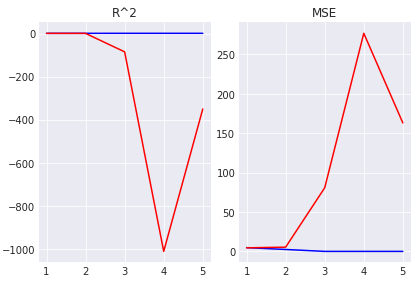

In [8]:
max_degrees = 5
degrees_range = np.arange(1, max_degrees + 1)

# linear regression with regularization
lm = LinearRegression()

eval_metrics_dict = linear_regression(lm, max_degrees)
plot_eval_metrics(degrees_range, eval_metrics_dict)

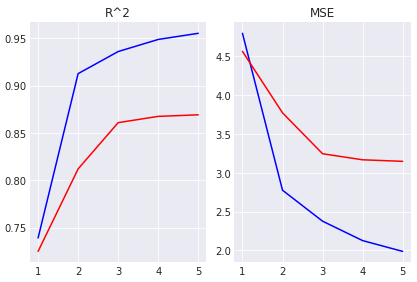

In [9]:
max_degrees = 5
degrees_range = np.arange(1, max_degrees + 1)

# linear regression with Lasso
lm = Lasso(alpha=0.001, max_iter=1000, normalize=True)

eval_metrics_dict = linear_regression(lm, max_degrees)
plot_eval_metrics(degrees_range, eval_metrics_dict)

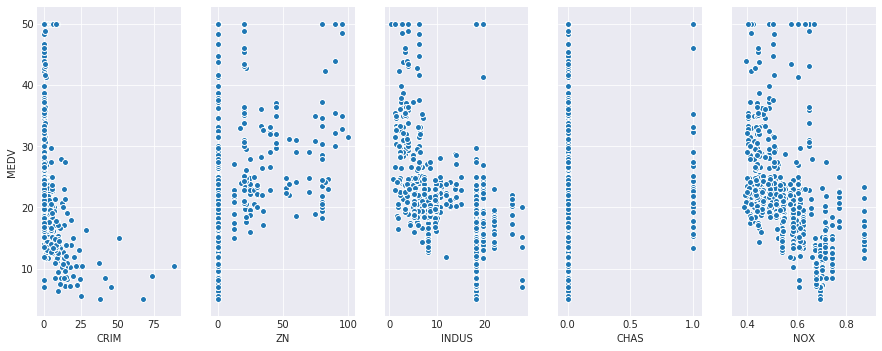

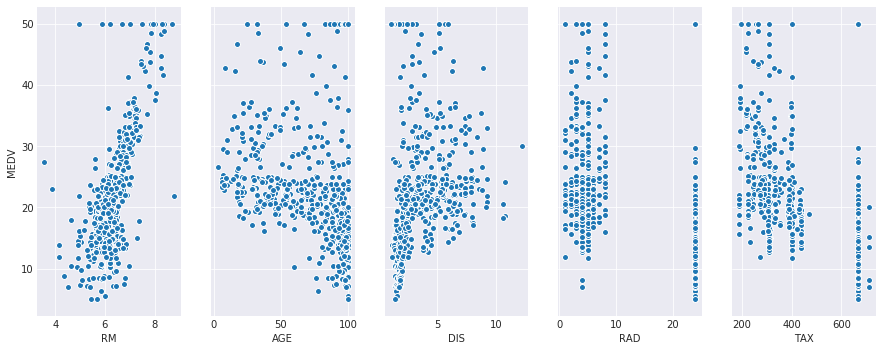

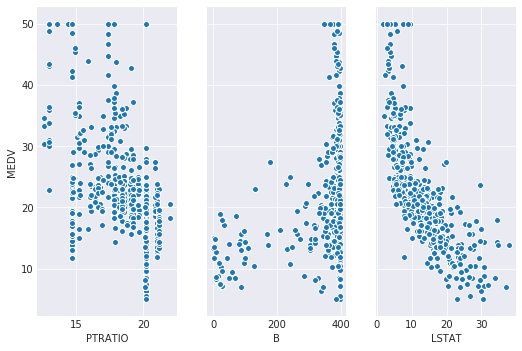

In [11]:
t = X.join(y)

with sns.axes_style('darkgrid'):
    sns.pairplot(t, x_vars=X.keys()[:5], y_vars=y.keys(), size=5, aspect=0.5)
    sns.pairplot(t, x_vars=X.keys()[5:10], y_vars=y.keys(), size=5, aspect=0.5)
    sns.pairplot(t, x_vars=X.keys()[10:14], y_vars=y.keys(), size=5, aspect=0.5)

#### Experiments with Cross Validation

Train score: 0.9160731797513989 
 Test Score: 0.7976135376613565 
 alpha: 0.0007896522868499724


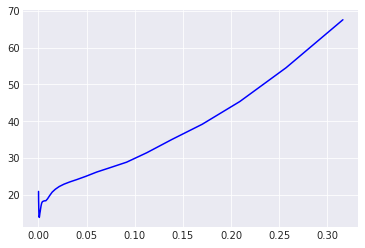

In [9]:
lasso_eps = 0.0001
lasso_iter=5000
alphas = np.logspace(-4, -0.5, 40)

lm_lasso = LassoCV(eps=lasso_eps, alphas=alphas, max_iter=lasso_iter, normalize=True, cv=10)

lasso_p = make_pipeline(PolynomialFeatures(2, interaction_only=False), lm_lasso)
lasso_p.fit(X_train, y_train.values.ravel())

lm_lasso_score = lasso_p.score(X_train, y_train.values.ravel())
lm_lasso_score_test = lasso_p.score(X_test, y_test.values.ravel())

print(f'Train score: {lm_lasso_score} \n Test Score: {lm_lasso_score_test} \n alpha: {lm_lasso.alpha_}')
mse_mean = np.mean(lm_lasso.mse_path_, axis=1)

with sns.axes_style('darkgrid'):
    plt.plot(lm_lasso.alphas_, mse_mean, color='blue')

### Pipeline with GridSearchCV

In [3]:

def run_polynomial_grid_pipeline(X_train, y_train, X_test, y_test, feature_result):

    steps = [
        ('poly', PolynomialFeatures()),
        ('regr', Lasso())
    ]
    pipeline = Pipeline(steps)
    
    parameters = {
        'poly__degree': [2, 3],
        'regr__alpha': np.logspace(-4, -0.5, 40)
    }
    
    grid = GridSearchCV(pipeline, param_grid=parameters, cv=10, n_jobs=-1)
    grid.fit(X_train, y_train)
    
    # train_score = grid.score(X_train, y_train)
    test_score = grid.score(X_test, y_test)
    
    y_predict_train = grid.predict(X_train)
    y_predict = grid.predict(X_test)
    
    print(grid.best_score_)
    print(grid.best_params_)
    print(test_score)
    
    if feature_result is not None:
        return eval_metrics(grid, X_train, y_train, y_predict_train, X_test, y_test, y_predict, feature_result)

In [4]:
# print('Running for all features...')
# run_polynomial_grid_pipeline(X_train, y_train, X_test, y_test, None)


feature_result = {
    'r2_train': [],
    'r2_test': [],
    'mse_train': [],
    'mse_test': [],
}

for num_features in np.arange(6, 12):

    k_best = SelectKBest(score_func=f_regression, k=num_features)
    k_best_fit = k_best.fit(X_train, y_train.values.ravel())
    
    score = k_best_fit.scores_
    new_X = k_best_fit.transform(X)
    
    # To see the score different feature wise
    #
    # features = boston_data.feature_names
    # d = dict(zip(features, score))
    
    print(f'\nRunning for {num_features} main features...')
    new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(new_X, y, test_size=0.33, random_state=42)
    feature_result = run_polynomial_grid_pipeline(new_X_train, new_y_train, new_X_test, new_y_test, feature_result)

    
feature_result


Running for 6 main features...


0.8254145382648234
{'poly__degree': 3, 'regr__alpha': 0.0001}
0.8210329210895668

Running for 7 main features...


0.8273761724940762
{'poly__degree': 3, 'regr__alpha': 0.0001}
0.8096772323249781

Running for 8 main features...


0.8077622436874856
{'poly__degree': 2, 'regr__alpha': 0.0001}
0.7827520027578161

Running for 9 main features...


0.8187232190688647
{'poly__degree': 2, 'regr__alpha': 0.0001}
0.8106317225378894

Running for 10 main features...


0.8112190789504492
{'poly__degree': 2, 'regr__alpha': 0.0014677992676220704}
0.8072160545530872

Running for 11 main features...


0.8298473597079276
{'poly__degree': 3, 'regr__alpha': 0.021544346900318846}
0.6967604456465541


{'mse_test': [3.680212165041698,
  3.7951736675634584,
  4.05475084045819,
  3.785645093164149,
  3.819633677407202,
  4.79048193327178],
 'mse_train': [3.080451444990105,
  2.9617338294286717,
  3.3210876609194937,
  3.0958193710408097,
  3.0197759490466027,
  2.284540093969564],
 'r2_test': [0.8210329210895668,
  0.8096772323249781,
  0.7827520027578161,
  0.8106317225378894,
  0.8072160545530872,
  0.6967604456465541],
 'r2_train': [0.892345009919189,
  0.9004829527241984,
  0.874868656356635,
  0.8912681802260252,
  0.8965441927966974,
  0.940788917815692]}

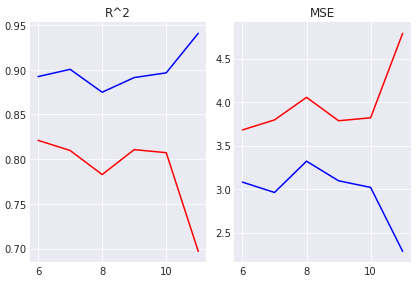

In [5]:
plot_eval_metrics(np.arange(6, 12), feature_result)